# **Automated Detection of Spam Comments on YouTube Using Natural Language Processing**

# **Data Loading & Robust Date Parsing**

In [ ]:
pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Load dataset
youtube_spam_collection = fetch_ucirepo(id=380)
df = pd.concat([youtube_spam_collection.data.features, youtube_spam_collection.data.targets], axis=1)

# Robust Date Cleaning: handles mixed formats and missing values
df['DATE'] = pd.to_datetime(df['DATE'], format='ISO8601', errors='coerce')
df['CONTENT'] = df['CONTENT'].astype(str)

print(f"Total rows: {len(df)}")
print(f"Rows with missing dates: {df['DATE'].isnull().sum()}")
df.head()

Total rows: 1956
Rows with missing dates: 245


,AUTHOR,DATE,CONTENT,CLASS
0,Julius NM,2013-11-07 06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,adam riyati,2013-11-07 12:37:15,Hey guys check out my new channel and our firs...,1
2,Evgeny Murashkin,2013-11-08 17:34:21,just for test I have to say murdev.com,1
3,ElNino Melendez,2013-11-09 08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,GsMega,2013-11-10 16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1


# **EDA**

## **Meta-Feature Analysis**

Average Metrics per Class (0=Ham, 1=Spam):
       char_count  word_count  capitals_count  punctuation_count
CLASS                                                           
0       49.644585    9.100946        3.502629           3.189274
1      137.341294   21.714428       14.471642           9.819900


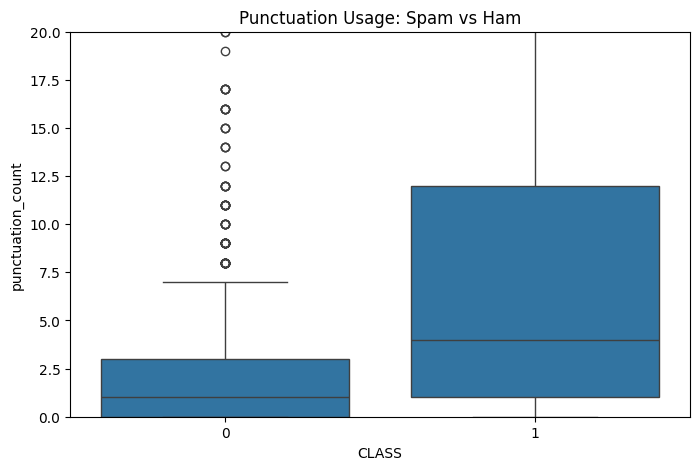

In [ ]:
# Feature Engineering for EDA
df['char_count'] = df['CONTENT'].apply(len)
df['word_count'] = df['CONTENT'].apply(lambda x: len(x.split()))
df['capitals_count'] = df['CONTENT'].apply(lambda x: sum(1 for c in x if c.isupper()))
df['punctuation_count'] = df['CONTENT'].apply(lambda x: sum(1 for c in x if c in string.punctuation))

# Comparing Averages
metrics = df.groupby('CLASS')[['char_count', 'word_count', 'capitals_count', 'punctuation_count']].mean()
print("Average Metrics per Class (0=Ham, 1=Spam):")
print(metrics)

# Visualizing Punctuation vs Class
plt.figure(figsize=(8, 5))
sns.boxplot(x='CLASS', y='punctuation_count', data=df)
plt.title('Punctuation Usage: Spam vs Ham')
plt.ylim(0, 20) # Clipping outliers for better view
plt.show()

## **Feature Correlation & Density Analysis**

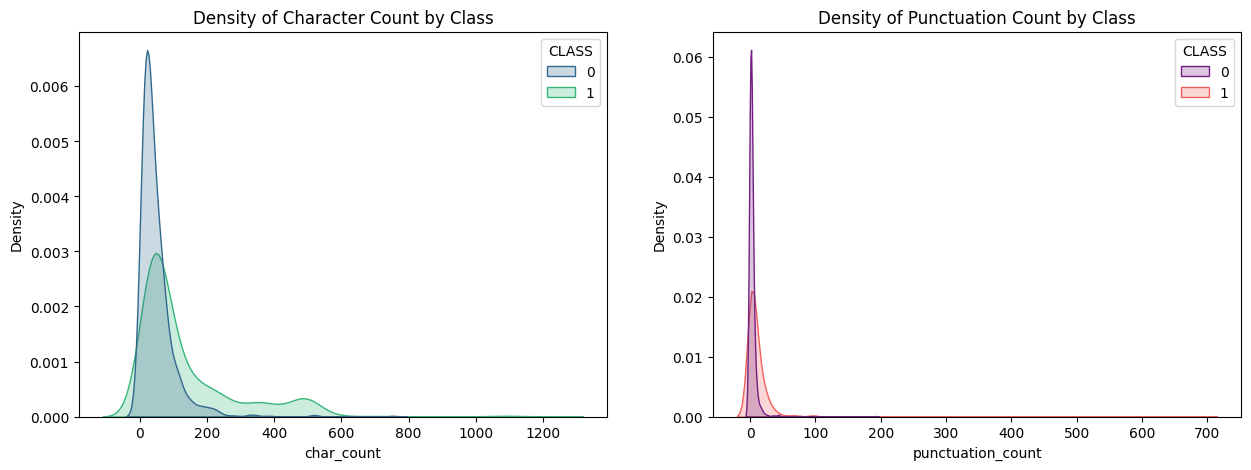

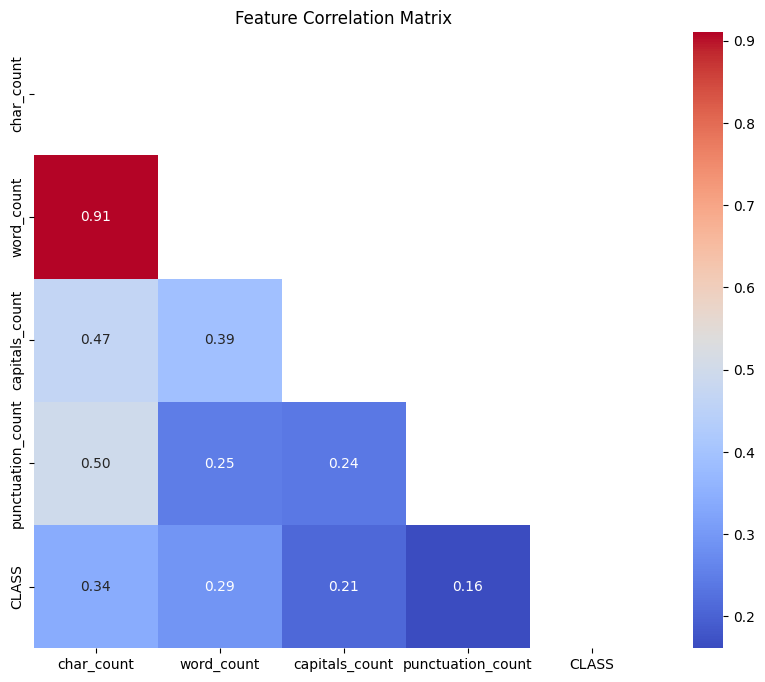

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering for deeper insights
df['char_count'] = df['CONTENT'].apply(len)
df['punctuation_count'] = df['CONTENT'].apply(lambda x: sum(1 for c in x if c in string.punctuation))
df['capitals_count'] = df['CONTENT'].apply(lambda x: sum(1 for c in x if c.isupper()))

# 1. Class-wise Density Plots
# These show the 'shape' of the data for Spam vs Ham
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.kdeplot(data=df, x='char_count', hue='CLASS', fill=True, ax=axes[0], palette='viridis')
axes[0].set_title('Density of Character Count by Class')

sns.kdeplot(data=df, x='punctuation_count', hue='CLASS', fill=True, ax=axes[1], palette='magma')
axes[1].set_title('Density of Punctuation Count by Class')
plt.show()

# 2. Correlation Heatmap (Triangular Matrix)
# Identifying which numerical features are redundant
plt.figure(figsize=(10, 8))
corr = df[['char_count', 'word_count', 'capitals_count', 'punctuation_count', 'CLASS']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

## **Bivariate Analysis: Pairplots**

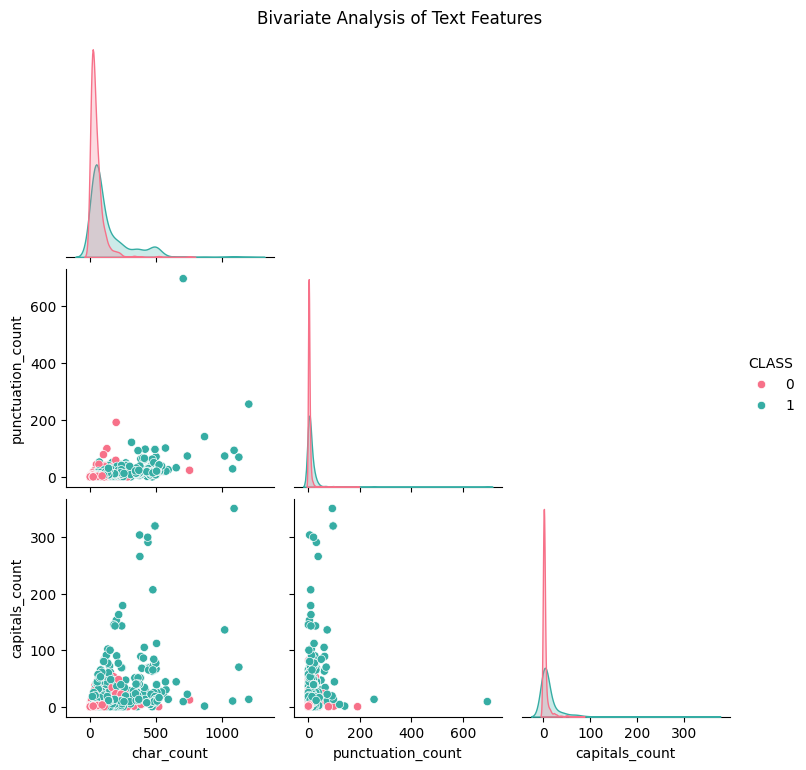

In [ ]:
# 3. Class-wise Pairplot
# This is a powerful way to see clusters in the data
sns.pairplot(df[['char_count', 'punctuation_count', 'capitals_count', 'CLASS']],
             hue='CLASS', palette='husl', corner=True)
plt.suptitle('Bivariate Analysis of Text Features', y=1.02)
plt.show()

# **Comprehensive Text Preprocessing**

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = nltk.stem.WordNetLemmatizer()

def clean_text_for_research(text):
    # 1. Lowercase
    text = text.lower()
    # 2. Remove URLs - very important for spam datasets
    text = re.sub(r'http\S+|www\S+|https\S+', '[URL]', text, flags=re.MULTILINE)
    # 3. Remove Special Characters/Numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # 4. Tokenize & Lemmatize
    tokens = text.split()
    # Removing stopwords and words shorter than 2 characters
    clean_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 1]

    return " ".join(clean_tokens)

# Apply to dataframe
df['PROCESSED_CONTENT'] = df['CONTENT'].apply(clean_text_for_research)

# Quick check on the result
print("\n--- Preprocessing Result ---")
print(f"Original: {df['CONTENT'].iloc[10]}")
print(f"Cleaned:  {df['PROCESSED_CONTENT'].iloc[10]}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...



--- Preprocessing Result ---
Original: Hey subscribe to me﻿
Cleaned:  hey subscribe


# **Visualizing Word Importance (N-Grams)**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

# Top bigrams in Spam
top_spam_bigrams = get_top_ngram(df[df['CLASS']==1]['PROCESSED_CONTENT'], 2)
print("Top 10 Spam Bigrams:", top_spam_bigrams)

Top 10 Spam Bigrams: [('check video', np.int64(140)), ('video youtube', np.int64(111)), ('check new', np.int64(63)), ('br br', np.int64(46)), ('check channel', np.int64(45)), ('subscribe channel', np.int64(43)), ('new mixtape', np.int64(39)), ('hey guy', np.int64(38)), ('check playlist', np.int64(37)), ('mixtape check', np.int64(36))]
